# New dataset for abundance analysis

## Things to do
* Separate samples into insulin/basal
* For abundance cut-offs, averages the metabolite abundance across samples in the same group
* For DE list, use paired t-tests to determine DE metabolites. Beware of the zeros.
* Check how long the list is

### Next step: paired t-tests

## class definition of a sample

In [1]:
class MetabolomicsSample:
    def __init__(self, sample_id, liver_fat, infusion, serum, patient_id):
        '''
        id, liver fat, insulin infusion, serum type, patient, compound:abundance
        '''
        self.sample_id = sample_id
        self.liver_fat = liver_fat
        self.infusion = infusion
        self.serum = serum
        self.patient_id = patient_id
        self._data = dict()
    
    def __repr__(self):
        return self.sample_id
    
    def getSampleInfo(self):
        print(self.sample_id)
        print("Liver fat(percentage):", self.liver_fat)
        print("Insulin infusion: " + self.infusion)
        print("Serum type: " + self.serum)
        print("Patient id: " + self.patient_id)
    
    def addOmicsData(self, metabolite_id, value):
        '''
        Find the existing entry of the metabolite in the data dictionary, add value to the existing entry
        If no existing entry can be found, create an entry for the metabolite
        Values have to be in float!!
        '''
        if not isinstance(value, float):
            print("Data values must be floats")
            return 0
        self._data[metabolite_id] = self._data.get(metabolite_id, 0) + value
        
    def getOmicsData(self):
        return self._data
    
    def clearOmicsData(self):
        self._data = dict()
        
    def avgOmicsData(self, replicate):
        '''
        Average the omics data from two replicates
        Return with a new object that has the average omics data
        ***If one replicate has 0 for a metabolite, the average will be 0
        
        Could potentially add an attribute that states whether a study has been averaged or not
        '''
        if not isinstance(replicate, MetabolomicsSample):
            print("Replicate must be a MetabolomicsSample sample")
            return 0
        elif (replicate.liver_fat != self.liver_fat or 
              replicate.infusion != self.infusion or 
              replicate.serum != self.serum or 
              replicate.patient_id != self.patient_id):
            print("Study info do not match")
            return 0
        mean_study = MetabolomicsSample(self.sample_id, self.liver_fat, 
                                        self.infusion, self.serum, self.patient_id)
        for metabolite in self.getOmicsData():
            if self.getOmicsData()[metabolite] == 0 or replicate.getOmicsData()[metabolite] == 0:
                avg_abundance = 0.0
            else:
                avg_abundance = (self.getOmicsData()[metabolite] + replicate.getOmicsData()[metabolite]) / 2
            mean_study.addOmicsData(metabolite, avg_abundance)
        return mean_study

## MTBLS298
242 Unique Chebi IDs

In [14]:
#directory = '/data/zx2313/MTBLS298/' # The location of the maf file
directory = '/home/zxu/Documents/mscbioinfo/data/MTBLS298/'
maf = directory + 'm_catheterization_study_metabolite_profiling_mass_spectrometry_v2_maf.tsv'
sample_info = directory + 's_Catheterization study.txt'

In [15]:
# Initialise metabolomics samples
met_studies = []
with open(sample_info, 'r') as fh:
    for line in fh.readlines()[1:]:
        fields = line.rstrip().split('\t')
        sample_id = fields[8][1:-1]
        liver_fat = int(fields[9][1:-1])
        infusion = fields[16][1:-1]
        serum = fields[19][1:-1]
        patient_id = fields[22][1:-1]
        met_studies.append(MetabolomicsSample(sample_id, liver_fat, infusion, serum, patient_id))

In [ ]:
for i in range(0, len(met_studies)):
    print(met_studies[i].patient_id)

In [5]:
print(met_studies)

[112Vein_pl01_GGT3_rep1run1_291009_1, 112Vein_pl01_GGT3_rep1run2_291009_1, 112Vein_pl05_GGT3_rep1run1_291009_1, 112Vein_pl05_GGT3_rep1run2_291009_1, 112Vein_pl09_GGT3_rep1run1_291009_1, 112Vein_pl09_GGT3_rep1run2_291009_1, 112Vein_pl13_GGT3_rep1run1_291009_1, 112Vein_pl13_GGT3_rep1run2_291009_1, 112Vein_pl17_GGT3_rep1run1_291009_1, 112Vein_pl17_GGT3_rep1run2_291009_1, 112Vein_pl21_GGT3_rep1run1_291009_1, 112Vein_pl21_GGT3_rep1run2_291009_1, 112Vein_pl25_GGT3_rep1run1_291009_1, 112Vein_pl25_GGT3_rep1run2_291009_1, 112Vein_pl29_GGT3_rep1run1_291009_1, 112Vein_pl29_GGT3_rep1run2_291009_1, 112Vein_pl33_GGT3_rep1run1_291009_1, 112Vein_pl33_GGT3_rep1run2_291009_1, 112Vein_pl02_GGT3_rep1run1_291009_1, 112Vein_pl02_GGT3_rep1run2_291009_1, 112Vein_pl06_GGT3_rep1run1_291009_1, 112Vein_pl06_GGT3_rep1run2_291009_1, 112Vein_pl26_GGT3_rep1run1_291009_1, 112Vein_pl26_GGT3_rep1run2_291009_1, 112Vein_pl30_GGT3_rep1run1_291009_1, 112Vein_pl30_GGT3_rep1run2_291009_1, 112Vein_pl34_GGT3_rep1run1_291009_1, 

In [22]:
with open(maf, 'r') as fh:
    study_indices = []
    lines = fh.readlines()
    for line in lines[0:1]:
        fields = line.rstrip().split('\t')
        #print(fields[0], fields[4], fields[11], fields[14], fields[16], fields[17], fields[21:81])# 0 4 11 14 16 17 21-80
        for field in fields[21:81]:
            sample_id = field[1:-5]
            for index in range(0, len(met_studies)):
                study = met_studies[index]
                if sample_id == study.sample_id:
                    study_indices.append(index)
                    
    for line in lines[1:]:
        fields = line.rstrip().split('\t')
        database_id = fields[0][1:-1]
        if not database_id.startswith('CHEBI'):
            continue # If the metabolite is not chebi, go to the next line
        else:
            converted_id = conv_chebi_kegg(database_id, ch)
        if not (converted_id.startswith('C') and len(converted_id) == 6):
            continue # If the converted id is not kegg, go to the next line
        for index in range(21, 81): #fields[21:81]:
            study_index = study_indices[index - 21]
            omics_value = float(fields[index][1:-1])
            met_studies[study_index].addOmicsData(converted_id, omics_value)

In [11]:
met_studies.sort(key = lambda x: x.patient_id)

In [12]:
basal_studies = []
insulin_studies = []
for study in met_studies:
    if study.infusion == 'Basal':
        basal_studies.append(study)
    elif study.infusion == 'Insulin':
        insulin_studies.append(study)

In [ ]:
for study in basal_studies:
    study.getSampleInfo()

In [ ]:
for study in insulin_studies:
    study.getSampleInfo()

In [13]:
avg_basal_studies = avg_replicates_study(basal_studies)
avg_insulin_studies = avg_replicates_study(insulin_studies)

In [16]:
for study in avg_basal_studies:
    print(study.patient_id)

1
1
2
2
3
4
5
6
8
8
9
9


In [17]:
for study in avg_insulin_studies:
    print(study.patient_id)

1
1
2
2
3
4
5
6
8
8
9
9


In [14]:
avg_basal_studies = avg_basal_studies[:8] + avg_basal_studies[10:]

In [15]:
avg_insulin_studies = avg_insulin_studies[:5] + avg_insulin_studies[6:7] + avg_insulin_studies[8:9] + avg_insulin_studies[10:11] + avg_insulin_studies[12:]

## Paired t-tests
- Conditions: basal vs insulin
- samples from the same patient and serum were paired together (12 vs 12)
- If a zero abundance is present for one metabolite, its abundance in the related sample will be also removed and excluded from the paired t-tests
- CONCERN: Small sample size (< 8) for Wilcoxon tests??
- before multiple-testing corrections: 11 DE metabolites
- after multiple-testing corrections: 1 DE metabolite
- 22/08: Multiple-testing corrections not important, so therefore they are removed
- 28/08: Changing p-val cutoff to get more DE metabolites. More DE metabolites did not improve pathway p-vals

In [19]:
import scipy.stats
# FDR
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

In [ ]:
# go through one metabolite in all samples
# do the same thing with the other condition
# if the paired t-test is significant, add the metabolite to the DE list
# if any zero is present in one sample, remove the related data in the other condition
p_cutoff = 1
de_metabolites = []
all_metabolites = list(avg_basal_studies[0].getOmicsData().keys())
for metabolite in all_metabolites:
    b_study_paired_abun = []
    i_study_paired_abun = []
    for index in range(0, len(avg_basal_studies)):
        b_study = avg_basal_studies[index]
        i_study = avg_insulin_studies[index]
        if b_study.getOmicsData()[metabolite] != 0.0 and i_study.getOmicsData()[metabolite] != 0.0:
            # if neither of the abundance is zero, add the data points to the paired list
            b_study_paired_abun.append(b_study.getOmicsData()[metabolite])
            i_study_paired_abun.append(i_study.getOmicsData()[metabolite])
    #print(len(b_study_paired_abun), len(i_study_paired_abun))
    if len(b_study_paired_abun) == 1 or len(i_study_paired_abun) == 1: # Skip this met if DOF too small
        continue
    p_val = scipy.stats.ttest_rel(b_study_paired_abun, i_study_paired_abun)[1]
    if p_val < p_cutoff:
        #print(metabolite, p_val)
        de_metabolites.append(metabolite)

In [21]:
de_metabolites

[C00187,
 C00346,
 C03969,
 C16440,
 C01601,
 C02001,
 C00109,
 C01607,
 C03189,
 C00872,
 C02020,
 C00989,
 C14200,
 C00026,
 C00429,
 C02498,
 C00122,
 C00160,
 C02277,
 C16436,
 C00219,
 C02057,
 C01733,
 C02341,
 C00303,
 C16433,
 C00490,
 C07514,
 C00074,
 C00597,
 C16438,
 C06337,
 C06104,
 C00503,
 C00954,
 C05587,
 C00233,
 C01536,
 C01420,
 C14693,
 C06142,
 C00302,
 C01571,
 C02679,
 C05984,
 C05410,
 C00164,
 C02226,
 C00158,
 C02693,
 C07086,
 C00156,
 C00090,
 C08261,
 C00587,
 C01595,
 C00383,
 C00184,
 C00116,
 C02385,
 C06423,
 C01401,
 C05942,
 C06772,
 C01108,
 C00037,
 C00086,
 C00246,
 C00716,
 C02287,
 C00469,
 C05593,
 C16834,
 C01384,
 C17714,
 C12486,
 C01753,
 C00806,
 C00146,
 C01432,
 C00137,
 C00078,
 C00334,
 C11505,
 C00249,
 C01530,
 C09822,
 C01620,
 C03894,
 C01879,
 C06255,
 C16439,
 C00022,
 C01602,
 C16435,
 C00791,
 C08348,
 C00712,
 C13101,
 C00042,
 C03758,
 C00805,
 C00379]

## Simulate DE metabolites
- 1: Pick a pathway from dataset_paths
- 2: Pick a proportion of its metabolites
- 3: Make them DE
- 4: ORA
- 5: Delete metabolites based on abundance

In [4]:
import random

In [5]:
# Simulating DE metabolites
def simulateDEmet(dataset_paths, sigpaths_num,
                  pathway_2_compounds, background_met,
                  verbose=False):
    augmented_paths = []
    for i in range(0, sigpaths_num): # Select significant pathways
        random.shuffle(dataset_paths)
        augmented_paths.append(dataset_paths[0])
        if verbose:
            print(dataset_paths[0])
    de_metabolites = set()
    for pathway in augmented_paths: # Make DE metabolites
        pathway_met = list(pathway_2_compounds[pathway] & background_met) # background mets which existed in KEGG pathway DB
        trim = int(len(pathway_met) * 0.6) + 1
        random.shuffle(pathway_met)
        pathway_met = pathway_met[:trim]
        de_metabolites = de_metabolites.union(pathway_met)
    if verbose:
        print(de_metabolites)
    return de_metabolites

In [30]:
dataset_paths = ora_msc.oras_allpaths(background_met, hsa_pathways, background_met, pathway_2_compounds, True, False, 0, [])[1]

In [32]:
de_metabolites = simulateDEmet(dataset_paths, 2, pathway_2_compounds, background_met, True)

path:hsa00860
path:hsa02010
{C00086, C00116, C00137, C00037}


In [41]:
for pathway in pathway_2_compounds:
    if len(pathway_2_compounds[pathway] & background_met) > 0:
        #print(pathway)
        #print(pathway_2_compounds[pathway] & background_met)
        #print('-' * 20)

108


## Calculate metabolite:abundance
- all zeros were excluded

In [26]:
import numpy as np
import operator

In [23]:
mets = list(met_studies[0].getOmicsData().keys())
#print(mets)
met_abundance = dict()
for study in met_studies:
    for metabolite in mets:
        #print(met_abundance)
        #print(metabolite)
        study_abundance = study.getOmicsData()[metabolite]
        #print(study_abundance)
        if study_abundance == 0:
            continue
        #print(study_abundance)
        try:
            met_abundance[metabolite].append(study_abundance)
        except KeyError:
            met_abundance[metabolite] = [study_abundance]

In [21]:
met_studies[0].getOmicsData()

{}

In [27]:
# Change all abundance to a mean abundance
for metabolite in met_abundance:
    mean_abundance = np.mean(met_abundance[metabolite])
    met_abundance[metabolite] = mean_abundance

In [28]:
# Sort metabolites based on their average abundance
sorted_met = sorted(met_abundance.items(), key=operator.itemgetter(1))

In [29]:
background_met = set(met_abundance.keys())

## ORA
- No significant pathways with the 11 DE metabolites input
- P-vals became worse as the DE metabolite cutoff increased...

In [9]:
kegg = KEGG()
kegg.organism = 'hsa'

In [10]:
hsa_pathways = kegg.pathwayIds
pathway_2_compounds = dict()
for pathway in hsa_pathways:
    parsed_output = kegg.parse(kegg.get(pathway)) # parsed_ouput has lots of information about the pathway
    try:
        compounds = set(parsed_output['COMPOUND'].keys())
        pathway_2_compounds[pathway] = compounds
    except KeyError: # Some pathways do not have defined compounds
        #name = parsed_output['NAME']
        #print(pathway, name)
        pass

In [29]:
#background_met = set(avg_basal_studies[0].getOmicsData().keys())
background_met = set(background_met)

In [21]:
len(background_met)

103

In [33]:
(path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(set(de_metabolites), hsa_pathways, background_met, pathway_2_compounds, True, False, 0, [])

In [34]:
for path in dict(zip(path_ids, path_pvals)):
    if dict(zip(path_ids, path_pvals))[path] < 0.05:
        print(path, dict(zip(path_ids, path_pvals))[path])

path:hsa00230 0.01003807545863589
path:hsa02010 8.117042149840193e-05
path:hsa00052 0.01003807545863589


In [64]:
pathway_2_compounds['path:hsa05030'] & background_met

{'C03758'}

In [35]:
# ORA with abundance cutoffs
#nums_removed_metabolites = [0, 25, 50, 75]
PVAL_CUTOFF = 0.05
de_metabolites = simulateDEmet(dataset_paths, 2, pathway_2_compounds, background_met)
(path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(set(de_metabolites), hsa_pathways, background_met,
                                                           pathway_2_compounds, True, False, 0, [])
correct_pathway_hits = set()
for path in dict(zip(path_ids, path_pvals)):
    if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
        correct_pathway_hits.add(path)

all_tested_paths = set(path_ids) # Store for the calculation of negatives

print('# DE metabolites:', de_metabolites)
print('# P-val cutoff:', PVAL_CUTOFF)
print('# Significant pathways:', str(len(correct_pathway_hits)))
print('removed', 'tp', 'fp', 'tn', 'fn', 'nonsig', 'lowmet', 'tested', 'accu', 'recall', 'precision', sep='\t')

for rem in range(0, 100, 10):
    new_de_mets = set()
    new_background = set()
    removed_mets = []
    new_pathway_hits = set()
    new_pathway_nonsig = set()
    new_pathway_negs = set()
    # Select removed metabolites and remove them from DE and background
    for item in sorted_met[:rem]:
        metabolite = item[0]
        removed_mets.append(metabolite)
    for metabolite in de_metabolites:
        if metabolite not in removed_mets:
            new_de_mets.add(metabolite)
    for metabolite in background_met:
        if metabolite not in removed_mets:
            new_background.add(metabolite)
    # ORA
    (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(new_de_mets, hsa_pathways, new_background,
                                                               pathway_2_compounds, True, False, 0, [])
    #if len(path_ids) == 0:
    #    pass
    # Report results
    for path in dict(zip(path_ids, path_pvals)):
        if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
            new_pathway_hits.add(path)
        else:
            new_pathway_nonsig.add(path)
    
    new_pathway_negs = all_tested_paths.difference(new_pathway_hits)
    
    tp = len(correct_pathway_hits & new_pathway_hits)
    fp = len(new_pathway_hits.difference(correct_pathway_hits))
    fn = len(new_pathway_negs & correct_pathway_hits)
    tn = len(new_pathway_negs.difference(correct_pathway_hits))
    fn_nonsig = len(new_pathway_nonsig & correct_pathway_hits)
    fn_lowmet = fn - fn_nonsig
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    recall = tp / (tp + fn)
    try:
        precision = tp /(tp + fp)
    except ZeroDivisionError:
        precision = np.NaN
    #print(len(path_ids))
    print(rem, tp, fp, tn, fn, fn_nonsig, fn_lowmet, len(path_ids),
          "%.2f" % accuracy, "%.2f" % recall, "%.2f" % precision, sep='\t')
    #print('=' * 10 + str(rem) + '='* 10)

# DE metabolites: {'C00187', 'C00219'}
# P-val cutoff: 0.05
# Significant pathways: 25
removed	tp	fp	tn	fn	nonsig	lowmet	tested	accu	recall	precision
0	25	0	3	0	0	0	28	1.00	1.00	1.00
10	25	1	2	0	0	0	28	0.96	1.00	0.96
20	25	1	2	0	0	0	28	0.96	1.00	0.96
30	20	0	3	5	5	0	28	0.82	0.80	1.00
40	21	0	3	4	4	0	28	0.86	0.84	1.00
50	21	0	3	4	4	0	28	0.86	0.84	1.00
60	2	0	3	23	23	0	28	0.18	0.08	1.00
70	2	0	3	23	23	0	28	0.18	0.08	1.00
80	2	0	3	23	23	0	28	0.18	0.08	1.00
90	0	0	3	25	25	0	28	0.11	0.00	nan


### Abundance analysis (Finally!!!)

In [41]:
# ORA with abundance cutoffs
#nums_removed_metabolites = [0, 25, 50, 75]
PVAL_CUTOFF = 0.05
fh = open('/home/zxu/Documents/github_local/ora-msc/data/' + 'abundance.tsv', 'a')

#fh.write('\t'.join(['# removed', 'tp', 'fp', 'tn', 'fn', 'nonsig', 'lowmet', 'tested', 'de', 'accu', 'recall', 'precision']))
#fh.write('\n')
#fh.write('# P-val cutoff: ')
#fh.write(str(PVAL_CUTOFF) + '\n')

for k in range(0, 250):
    de_metabolites = simulateDEmet(dataset_paths, 2, pathway_2_compounds, background_met)
    (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(set(de_metabolites), hsa_pathways, background_met,
                                                               pathway_2_compounds, True, False, 0, [])
    correct_pathway_hits = set()
    for path in dict(zip(path_ids, path_pvals)):
        if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
            correct_pathway_hits.add(path)
    # If no significant pathways, run again
    # (Seems it does not work the way I wanted)
    if len(correct_pathway_hits) == 0:
        k -= 1
        continue
        
    all_tested_paths = set(path_ids) # Store for the calculation of negatives
    
    fh.write('# DE metabolites: ')
    fh.write(','.join(list(de_metabolites)))
    fh.write('\n')
    fh.write('# Significant pathways: ')
    fh.write(str(len(correct_pathway_hits)) + '\n')

    for rem in range(0, 100, 10):
        new_de_mets = set()
        new_background = set()
        removed_mets = []
        new_pathway_hits = set()
        new_pathway_nonsig = set()
        new_pathway_negs = set()
        # Select removed metabolites and remove them from DE and background
        for item in sorted_met[:rem]:
            metabolite = item[0]
            removed_mets.append(metabolite)
        for metabolite in de_metabolites:
            if metabolite not in removed_mets:
                new_de_mets.add(metabolite)
        for metabolite in background_met:
            if metabolite not in removed_mets:
                new_background.add(metabolite)
        # ORA
        (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(new_de_mets, hsa_pathways, new_background,
                                                                   pathway_2_compounds, True, False, 0, [])
        #if len(path_ids) == 0:
        #    pass
        # Report results
        for path in dict(zip(path_ids, path_pvals)):
            if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
                new_pathway_hits.add(path)
            else:
                new_pathway_nonsig.add(path)
                
        new_pathway_negs = all_tested_paths.difference(new_pathway_hits)
                
        tp = len(correct_pathway_hits & new_pathway_hits)
        fp = len(new_pathway_hits.difference(correct_pathway_hits))
        fn = len(new_pathway_negs & correct_pathway_hits)
        tn = len(new_pathway_negs.difference(correct_pathway_hits))
        fn_nonsig = len(new_pathway_nonsig & correct_pathway_hits)
        fn_lowmet = fn - fn_nonsig
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        recall = tp / (tp + fn)
        try:
            precision = tp /(tp + fp)
        except ZeroDivisionError:
            precision = np.NaN
        #print(len(path_ids))
        #'\t'.join(list(map(str, [rem, tp, fp, tn, fn])))
        fh.write('\t'.join(list(map(str, [rem, tp, fp, tn, fn, fn_nonsig, fn_lowmet, len(path_ids), len(new_de_mets),
                                          "%.2f" % accuracy, "%.2f" % recall, "%.2f" % precision]))))
        fh.write('\n')
        #print('=' * 10 + str(rem) + '='* 10)
fh.close()

In [37]:
# ORA with abundance cutoffs
#nums_removed_metabolites = [0, 25, 50, 75]
PVAL_CUTOFF = 0.05
fh = open('/home/zxu/Documents/github_local/ora-msc/data/' + 'shrink.tsv', 'a')

#fh.write('\t'.join(['# removed', 'tp', 'fp', 'tn', 'fn', 'nonsig', 'lowmet', 'tested', 'de', 'accu', 'recall', 'precision']))
#fh.write('\n')
#fh.write('# P-val cutoff: ')
#fh.write(str(PVAL_CUTOFF) + '\n')


for k in range(0, 50):
    de_metabolites = simulateDEmet(dataset_paths, 2, pathway_2_compounds, background_met)
    (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(set(de_metabolites), hsa_pathways, background_met,
                                                               pathway_2_compounds, True, False, 0, [])
    correct_pathway_hits = set()
    for path in dict(zip(path_ids, path_pvals)):
        if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
            correct_pathway_hits.add(path)
    # If no significant pathways, run again
    if len(correct_pathway_hits) == 0:
        k -= 1
        continue
    
    all_tested_paths = set(path_ids) # Store for the calculation of negatives
    
    fh.write('# DE metabolites: ')
    fh.write(','.join(list(de_metabolites)))
    fh.write('\n')
    fh.write('# Significant pathways: ')
    fh.write(str(len(correct_pathway_hits)) + '\n')

    for i in range(0, 50):
    
        # Shuffle background met so they can be randomly removed
        metlist = list(background_met)
        random.shuffle(metlist)
        
        for rem in range(0, 100, 10):
            new_de_mets = set()
            new_background = set()
            removed_mets = []
            new_pathway_hits = set()
            new_pathway_nonsig = set()
            new_pathway_negs = set()
            # Select removed metabolites and remove them from DE and background
            for metabolite in metlist[:rem]:
                removed_mets.append(metabolite)
            for metabolite in de_metabolites:
                if metabolite not in removed_mets:
                    new_de_mets.add(metabolite)
            for metabolite in background_met:
                if metabolite not in removed_mets:
                    new_background.add(metabolite)
            # ORA
            (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(new_de_mets, hsa_pathways, new_background,
                                                                       pathway_2_compounds, True, False, 0, [])
            if len(path_ids) == 0:
                pass
            # Report results
            for path in dict(zip(path_ids, path_pvals)):
                if dict(zip(path_ids, path_pvals))[path] < PVAL_CUTOFF:
                    new_pathway_hits.add(path)
                else:
                    new_pathway_nonsig.add(path)

            new_pathway_negs = all_tested_paths.difference(new_pathway_hits)
                
            tp = len(correct_pathway_hits & new_pathway_hits)
            fp = len(new_pathway_hits.difference(correct_pathway_hits))
            fn = len(new_pathway_negs & correct_pathway_hits)
            tn = len(new_pathway_negs.difference(correct_pathway_hits))
            fn_nonsig = len(new_pathway_nonsig & correct_pathway_hits)
            fn_lowmet = fn - fn_nonsig
            accuracy = (tp + tn) / (tp + fp + fn + tn)
            recall = tp / (tp + fn)
            try:
                precision = tp /(tp + fp)
            except ZeroDivisionError:
                precision = np.NaN
        
            #print(len(path_ids))
            #'\t'.join(list(map(str, [rem, tp, fp, tn, fn])))
            fh.write('\t'.join(list(map(str, [rem, tp, fp, tn, fn, fn_nonsig, fn_lowmet, len(path_ids), len(new_de_mets),
                                              "%.2f" % accuracy, "%.2f" % recall, "%.2f" % precision]))))
            fh.write('\n')
            #print('=' * 10 + str(rem) + '='* 10)
fh.close()

KeyboardInterrupt: 

## Null models (Liver dataset)

In [78]:
hsa_cmpds = list(ora_msc.get_all_compounds('hsa'))

{'path:hsa00010': {'C00004',
  'C00015',
  'C00436',
  'C00504',
  'C00526',
  'C00580',
  'C00922',
  'C00935',
  'C00955',
  'C01004',
  'C01107',
  'C01272',
  'C02593',
  'C03064',
  'C03145',
  'C03289',
  'C03885',
  'C05280',
  'C05748',
  'C05859',
  'C06240',
  'C06865',
  'C06999',
  'C11436',
  'C11522',
  'C14797',
  'C18290',
  'C20466',
  'G00015',
  'G00132',
  'G13093'},
 'path:hsa00020': {'C00015',
  'C00036',
  'C00450',
  'C01004',
  'C01743',
  'C02593',
  'C02739',
  'C03885',
  'C04076',
  'C05844',
  'C05859',
  'C05981',
  'C06240',
  'C06865',
  'C14797',
  'C20640',
  'C20897',
  'C20970',
  'G00015',
  'G13046'},
 'path:hsa00030': {'C00203',
  'C00624',
  'C00919',
  'C00935',
  'C00955',
  'C01036',
  'C01107',
  'C01272',
  'C01623',
  'C02273',
  'C02530',
  'C02647',
  'C03289',
  'C03885',
  'C03974',
  'C04088',
  'C04498',
  'C05264',
  'C06038',
  'C06146',
  'C06999',
  'C11436',
  'C11457',
  'C13856',
  'C15915',
  'C16091',
  'C17332',
  'C18154',

In [159]:
{'C00187', C17714, C16834, 'C00219', C00334}
for k in range(0, 10):
    null_model = ora_msc.make_null_model(pathway_2_compounds, hsa_cmpds, True)
    (path_pvals, path_ids, path_sizes) = ora_msc.oras_allpaths(set(de_metabolites), hsa_pathways, set(background_met),
                                                               null_model, True, False, 0, [])
    for path in dict(zip(path_ids, path_pvals)):
        if dict(zip(path_ids, path_pvals))[path] < 0.05:
            print(path, dict(zip(path_ids, path_pvals))[path])
            print(null_model[path] & background_met)
    print(path_sizes)
    print('=' * 20)

[1, 1, 2]
[1, 1, 2, 1, 1, 1]
path:hsa00860 0.04854368932039008
{C00503, C00074, C00158, C00146, C00187, C00219}
path:hsa00051 0.04854368932039008
{'C00334'}
[1, 6]
path:hsa01040 0.04854368932039008
{'C00334'}
path:hsa00590 0.04854368932039008
{'C00187'}
path:hsa00565 0.04854368932039008
{'C00219'}
path:hsa04726 0.04854368932039008
{'C00187'}
[1, 1, 1, 1]
path:hsa04973 0.04854368932039008
{'C00219'}
path:hsa00980 0.011195865445944489
{C00187, C00334, C00791}
[3, 1]
[2, 1, 1, 2]
[1, 2, 5]
path:hsa00440 0.005711022272986752
{'C00187', 'C00219'}
[3, 2, 1]
[2, 1, 5]
[1, 2, 1]


### Larger background with less de_size = worse fpr
- Min num of pathway size should be adjusted according to these two values
- When bg = 100, 

In [151]:
PATHWAY_COMPOUND_SIZE = 2
PATHWAY_DE_METABOLITES = 1
BACKGROUND_SIZE = 108
DE_MET_SIZE = 5

for DE_MET_SIZE in range(5, 6):
    hyperg_test = hypergeom(BACKGROUND_SIZE, PATHWAY_COMPOUND_SIZE, DE_MET_SIZE)
    ora_raw_pval = 1 - hyperg_test.cdf(PATHWAY_DE_METABOLITES) + hyperg_test.pmf(PATHWAY_DE_METABOLITES)
    print(ora_raw_pval)

0.0908618899273


## Conversion: Chebi to KEGG

In [6]:
from bioservices import KEGG, ChEBI
import ora_msc

In [7]:
ch = ChEBI()

In [8]:
def conv_chebi_kegg(chebi_id, chebi_instance):
    '''
    converting chebi ids to kegg ids
    if the chebi entry does not have database links
    return the ascii name of that entry
    '''
    res = chebi_instance.getCompleteEntity(chebi_id)
    try:
        for link in res.DatabaseLinks:
            if link.type == 'KEGG COMPOUND accession':
                kegg_id = link.data
                return kegg_id
    except AttributeError:
        pass
    return res.chebiAsciiName

def avg_replicates_study(repstudies):
    '''
    Only works when there are exactly two replicates
    Must sort the input list by patient id first!!!
    '''
    avg_studies = []
    for i in range(0, len(repstudies), 2):
        study_rep1 = repstudies[i]
        study_rep2 = repstudies[i+1]
        study_avg = study_rep1.avgOmicsData(study_rep2)
        avg_studies.append(study_avg)
    return avg_studies

## Analysing abundance & random results

In [64]:
def plot_dict(in_dict):
    xvals = []
    yvals = []
    sorted_keys = sorted(list(in_dict.keys()))[::-1]
    for key in sorted_keys:
        xvals.append(key)
        yvals.append(in_dict[key])
    print(xvals)
    print(yvals)
    plt.plot(xvals, yvals)
    plt.show()

In [36]:
abun_results = '/home/zxu/Documents/github_local/ora-msc/data/' + 'abundance.tsv'
shrink_results = '/home/zxu/Documents/github_local/ora-msc/data/' + 'shrink.tsv'

In [94]:
de_simcount = 0
de_mets_vs_sigpaths = dict()
with open(abun_results, 'r') as fh:
    lines = fh.readlines()
    for line in lines[2:]:
        if line.startswith('# DE'):
            de_mets = line.rstrip().split(': ')[1]
            de_mets = de_mets.split(',')
        elif line.startswith('# Sig'):
            sigpaths = int(line.rstrip().split(': ')[1])
            de_simcount += 1
            try:
                de_mets_vs_sigpaths[len(de_mets)].append(sigpaths)
            except KeyError:
                de_mets_vs_sigpaths[len(de_mets)] = [sigpaths]
for key in de_mets_vs_sigpaths:
    de_mets_vs_sigpaths[key] = np.sum(de_mets_vs_sigpaths[key])

In [98]:
de_simcount

282

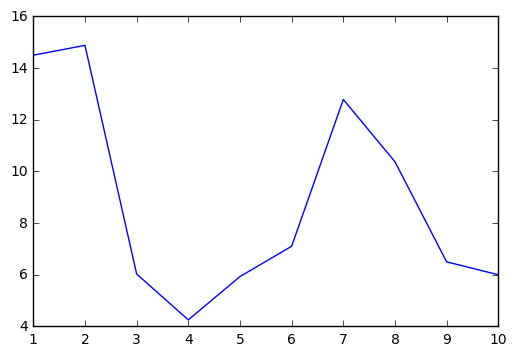

In [58]:
import matplotlib.pyplot as plt
plot_dict(de_mets_vs_sigpaths)

In [74]:
accu_vs_remove = dict()
recall_vs_remove = dict()
with open(abun_results, 'r') as fh:
    lines = fh.readlines()
    for line in lines:
        if not line.startswith('#'):
            fields = line.rstrip().split('\t')
            removed = fields[0]
            accu = float(fields[9])
            recall = float(fields[10])
            try:
                accu_vs_remove[removed].append(accu)
            except KeyError:
                accu_vs_remove[removed] = [accu]
            try:
                recall_vs_remove[removed].append(recall)
            except KeyError:
                recall_vs_remove[removed] = [recall]
for key in accu_vs_remove:
    accu_vs_remove[key] = np.mean(accu_vs_remove[key])
for key in recall_vs_remove:
    recall_vs_remove[key] = np.mean(recall_vs_remove[key])

In [78]:
accu_vs_remove

{'0': 1.0,
 '10': 0.91751773049645391,
 '20': 0.88719858156028364,
 '30': 0.88028368794326239,
 '40': 0.87549645390070918,
 '50': 0.86095744680851072,
 '60': 0.82124113475177296,
 '70': 0.78024822695035456,
 '80': 0.7466666666666667,
 '90': 0.75241134751773053}

['90', '80', '70', '60', '50', '40', '30', '20', '10', '0']
[0.75241134751773053, 0.7466666666666667, 0.78024822695035456, 0.82124113475177296, 0.86095744680851072, 0.87549645390070918, 0.88028368794326239, 0.88719858156028364, 0.91751773049645391, 1.0]


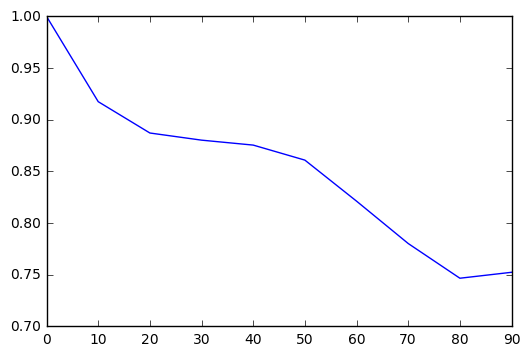

In [77]:
plot_dict(accu_vs_remove)

In [83]:
last_fp = 0
last_de = 100
increased_fp = []
decreased_de = []
with open(abun_results, 'r') as fh:
    lines = fh.readlines()
    for line in lines:
        if not line.startswith('#'):
            fields = line.rstrip().split('\t')
            fp = int(fields[2])
            de = int(fields[8])
            if fp > last_fp and de < last_de:
                increased_fp.append(1)
                decreased_de.append(1)
            elif fp > last_fp and de == last_de:
                increased_fp.append(0)
            elif de < last_de:
                decreased_de.append(0)
            last_fp = fp
            last_de = de

In [87]:
print(np.sum(increased_fp))
print(np.sum(decreased_de))

147
147


In [86]:
print(len(increased_fp))
print(len(decreased_de))

249
683
